### Imports

In [1]:
import argparse
from inspect import currentframe, getframeinfo
from glob import glob
from pathlib import Path
import os
from os.path import join
import pandas as pd
import pickle
import sys

import numpy as np

import nibabel as nib
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import make_first_level_design_matrix
from nistats.reporting import plot_design_matrix, plot_contrast_matrix

from utils.events_utils_nistats import get_beta_series, get_contrasts, parse_EVs, process_confounds

/usr/local/miniconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/miniconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 1stlevel_analysis.ipynb

In [2]:
parser = argparse.ArgumentParser(description='Example BIDS App entrypoint script.')
parser.add_argument('-data_dir', default='/data')
parser.add_argument('-derivatives_dir', default=None)
parser.add_argument('-working_dir', default=None)
parser.add_argument('--subject_ids', nargs="+")
parser.add_argument('--tasks', nargs="+", help="Choose from ANT, CCTHot, discountFix, \
                                    DPX, motorSelectiveStop, stopSignal, \
                                    stroop, surveyMedley, twoByTwo, WATT3")
parser.add_argument('--skip_beta', action='store_false')
parser.add_argument('--skip_contrast', action='store_false')
parser.add_argument('--n_procs', default=16, type=int)
if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.data_dir = '/data'
    args.derivatives_dir = '/data/derivatives'
    args.tasks = ['ANT', 'stroop']
    args.subject_ids = ['s358']
    args.n_procs=4

### Initial Setup

In [3]:
# get current directory to pass to function nodes
filename = getframeinfo(currentframe()).filename
current_directory = str(Path(filename).resolve().parent)

# list of subject identifiers
subjects = args.subject_ids
# set task
tasks = args.tasks

#### Experiment Variables
derivatives_dir = args.derivatives_dir
fmriprep_dir = join(derivatives_dir, 'fmriprep', 'fmriprep')
data_dir = args.data_dir
first_level_dir = join(derivatives_dir,'1stlevel')
if args.working_dir is None:
    working_dir = join(derivatives_dir, '1stlevel_workingdir')
else:
    working_dir = join(args.working_dir, '1stlevel_workingdir')
run_beta = args.skip_beta
run_contrast = args.skip_contrast
n_procs = args.n_procs
# TR of functional images
TR = .68

In [4]:
# print
print('*'*79)
print('Tasks: %s\n, Subjects: %s\n, derivatives_dir: %s\n, data_dir: %s' % 
     (tasks, subjects, derivatives_dir, data_dir))
print('Running Contrast?: %s, Running Beta?: %s' % 
     (['No','Yes'][run_contrast], ['No','Yes'][run_beta]))
print('*'*79)

*******************************************************************************
Tasks: ['ANT', 'stroop']
, Subjects: ['s358']
, derivatives_dir: /data/derivatives
, data_dir: /data
Running Contrast?: Yes, Running Beta?: Yes
*******************************************************************************


# Set up Nodes

### Define helper functions

In [5]:
def get_func_file(fmriprep_dir, subject_id, task):
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    # get mask_file
    func_file = glob(join(fmriprep_dir,
                          'sub-%s' % subject_id,
                          '*', 'func',
                          '*%s*MNI*preproc.nii.gz' % task))
    
    # get mask_file
    mask_file = glob(join(fmriprep_dir,
                          'sub-%s' % subject_id,
                          '*', 'func',
                          '*%s*MNI*brainmask.nii.gz' % task))
    if not func_file or not mask_file:
        return None, None
    return func_file[0], mask_file[0]

def get_confounds(fmriprep_dir, subject_id, task):
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    ## Get the Confounds File (output of fmriprep)
    # Read the TSV file and convert to pandas dataframe
    confounds_file = glob(join(fmriprep_dir,
                               'sub-%s' % subject_id,
                               '*', 'func',
                               '*%s*confounds.tsv' % task))[0]
    regressors, regressor_names = process_confounds(confounds_file)
    confounds = pd.DataFrame(regressors, columns=regressor_names)
    return confounds
    
def get_events(data_dir, subject_id, task):
    ## Get the Events File if it exists
    # Read the TSV file and convert to pandas dataframe
    event_file = glob(join(data_dir,
                           'sub-%s' % subject_id,
                           '*', 'func',
                           '*%s*events.tsv' % task))[0]   
    events_df = pd.read_csv(event_file,sep = '\t')
    return events_df

def create_design(events, confouds, task, beta=True):
    if beta:
        EV_dict = get_beta_series(events, regress_rt=False)
    else:
        EV_dict = parse_EVs(events, task)
    # coonvert nipype format to nistats paradigm
    conditions = []
    onsets = []
    amplitudes = []
    durations = []
    for i in range(len(EV_dict['conditions'])):
        onset = EV_dict['onsets'][i]
        onsets += onset
        # add on conditions
        conditions += [EV_dict['conditions'][i]]*len(onset)
        duration = EV_dict['durations'][i]
        # add on duration, and extend if the array has a length of one
        if len(duration) == 1 and len(onset) > 1:
            duration *= len(onset)
        durations += duration
        # add on amplitude, and extend if the array has a length of one
        amplitude = EV_dict['amplitudes'][i]
        if len(amplitude) == 1 and len(onset) > 1:
            amplitude *= len(onset)
        amplitudes += amplitude
    paradigm = {'trial_type': conditions,
               'onset': onsets,
               'modulation': amplitudes,
               'duration': durations}
    # make design
    n_scans = confounds.shape[0]
    design = make_first_level_design_matrix(np.arange(n_scans)*TR,
                               paradigm,
                               drift_model='cosine',
                               add_regs=confounds.values,
                               add_reg_names=list(confounds.columns))
    return design

def get_contrasts(task, design_matrix):
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    if task == 'ANT':
        contrasts = [('task', 'task'),
                    ('RT','response_time'),
                    ('congruent', 'congruent'),
                    ('orienting_network', 'spatial-double'),
                    ('conflict_network', 'incongruent-congruent')]
        
    elif task == 'stroop':
        contrasts = [('task', 'task'),
                    ('RT','response_time'),
                    ('congruent', 'congruent'),
                    ('stroop', 'incongruent-congruent')]
    
    return contrasts

In [6]:
from collections import namedtuple
SubjInfo = namedtuple('subjinfo', ['func','mask','design','contrasts','ID'])
class FirstLevel():
    def __init__(self, func, mask, design, contrasts, ID):
        self.func = func
        self.mask = mask
        self.design = design
        self.contrasts = contrasts
        self.ID = ID
        # once analysis has been run
        self.fit_model = None
        self.maps = {}
    
    def get_subjinfo(self):
        return SubjInfo(self.func, 
                        self.mask, 
                        self.design, 
                        self.contrasts, 
                        self.ID)

In [7]:
to_run = []
for subject_id in subjects:
    for task in tasks:
        func_file, mask_file = get_func_file(fmriprep_dir, subject_id, task)
        if func_file is None or mask_file is None:
            print("Missing files for %s: %s" % (subject_id, task))
            continue
        events = get_events(data_dir, subject_id, task)
        confounds = get_confounds(fmriprep_dir, subject_id, task)
        design = create_design(events, confounds, task, beta=False)
        contrasts = get_contrasts(task, design)
        subjinfo = FirstLevel(func_file, mask_file, design, contrasts, '%s_%s' % (subject_id, task))
        to_run.append(subjinfo)

/usr/local/miniconda/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/usr/local/miniconda/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/usr/local/miniconda/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/usr/local/miniconda/lib/python3.6/site-packages/nistats/utils.py:262: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


/usr/local/miniconda/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


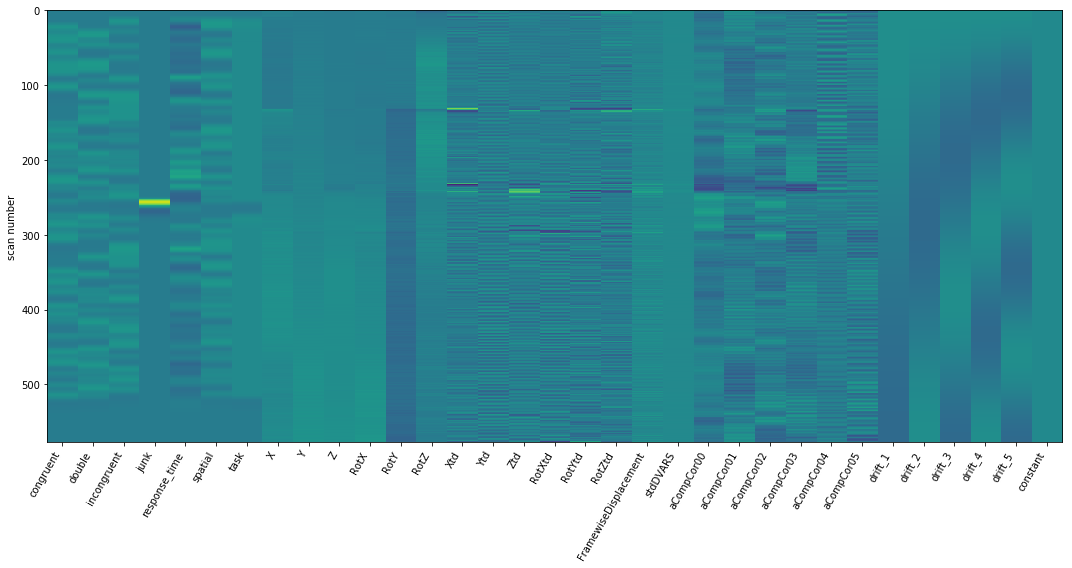

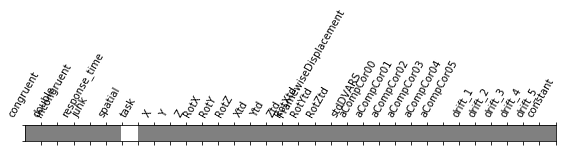

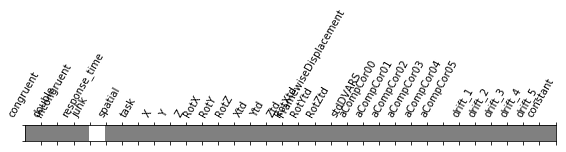

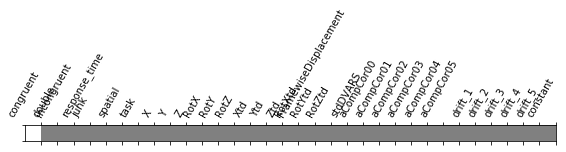

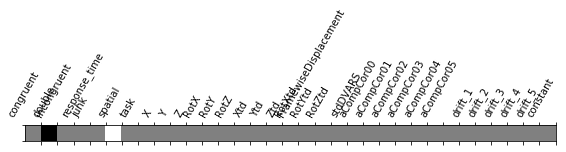

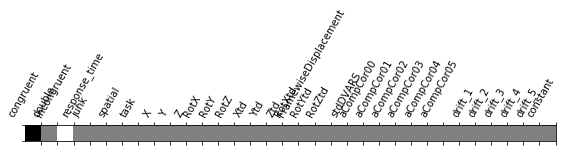

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,8))
plot_design_matrix(to_run[0].design, ax=ax, rescale=True)

for name, contrast in to_run[0].contrasts:
    plot_contrast_matrix(contrast, design_matrix=to_run[0].design)

In [9]:
"""
compare to things I did before:
high pass filter (80hz)
model_serial_correlations
"""

for subjinfo in to_run:
    fmri_glm = FirstLevelModel(TR, 
                           noise_model='ar1',
                           standardize=False, 
                           hrf_model='glover+derivative',
                           drift_model=None,
                           period_cut=160,
                           smoothing_fwhm=4.4, # remove when doing this for real?
                           mask=subjinfo.mask
                          )
    out = fmri_glm.fit(subjinfo.func, design_matrices=subjinfo.design)
    subjinfo.fit_model = out

In [10]:
for subjinfo in to_run:
    for name, contrast in subjinfo.contrasts:
        z_map = subjinfo.fit_model.compute_contrast(contrast, output_type='z_score')
        subjinfo.maps[name+'_zscore'] = z_map

/usr/local/miniconda/lib/python3.6/site-packages/nistats/model.py:199: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))
/usr/local/miniconda/lib/python3.6/site-packages/nistats/utils.py:286: RuntimeWarning: invalid value encountered in less_equal
  return np.where(X <= 0, 0, 1. / X)
/usr/local/miniconda/lib/python3.6/site-packages/nistats/utils.py:286: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/usr/local/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/miniconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value enco

/usr/local/miniconda/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3
/usr/local/miniconda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


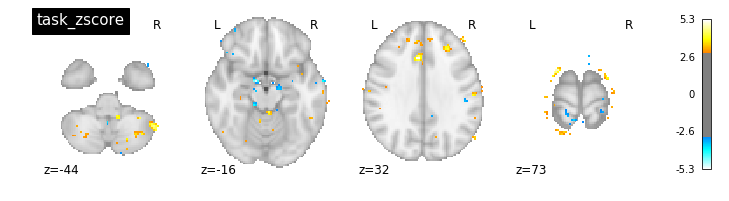

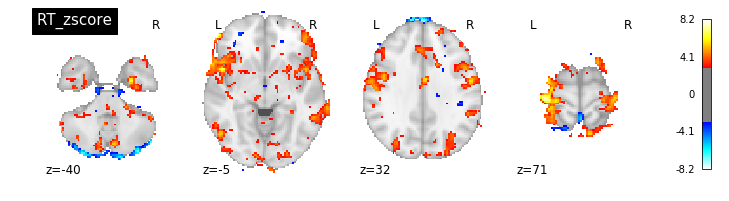

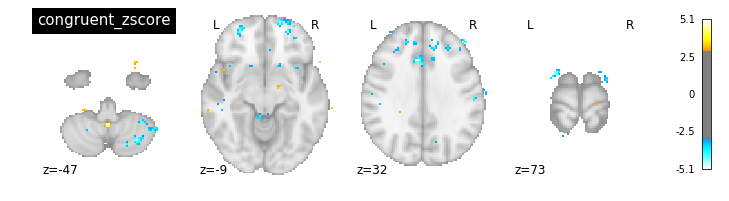

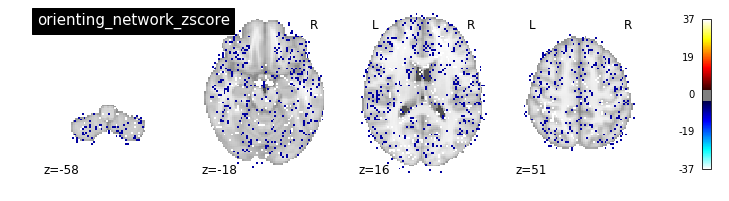

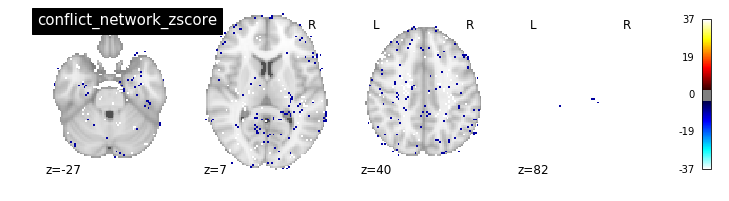

In [11]:
from nilearn import plotting
subjinfo = to_run[0]
for ID, z_map in subjinfo.maps.items():
    plotting.plot_stat_map(
                z_map, display_mode='z', threshold=3.0, title=ID,  cut_coords=4)